## Getting token for cds climate store

In [1]:
import psycopg2
import pandas.io.sql as sqlio
import getpass
import cdsapi
from fabric import Connection
from joblib import Parallel,delayed
import datetime
from tqdm import tqdm
import os
import uuid
import xarray as xr
import matplotlib.pyplot as plt

key = getpass.getpass('mobiserver password: ')
vaultKey = getpass.getpass('vault password: ')
#Querying necessary tokens
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host='mobiserver.niva.no', port=5432, database='vault',password=key) as db:
        with db.cursor() as cursor :
            cursor.execute(query)
            if fetch:
                result = sqlio.read_sql_query(query, db)
                return result
            
copernicusKey = query('''select niva.getToken('copernicusKey','{}');'''.format(vaultKey)).iloc[0,0]

del key,vaultKey

with Connection('localhost') as c:
    c.local('rm -f /home/jovyan/.cdsapirc')
    c.local('touch /home/jovyan/.cdsapirc') 
    c.local('''echo "url: https://cds.climate.copernicus.eu/api/v2\n" >>/home/jovyan/.cdsapirc''')
    c.local('''echo "key: {}" >>/home/jovyan/.cdsapirc'''.format(copernicusKey))
    
del copernicusKey

mobiserver password:  ·······
vault password:  ···············


## Querying data from the climate datastore

With the key obtained above, we can download data from the copernicus climate datastore. 
The available datasets are listed in https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset 

Let's try getting the potential evapotranspiration directly from the era5-land dataset: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview

The ERA-5 dataset covers the whole world. We will only store data from Europe. It will be extracted from the (remote) global data using the fimex tool.  

In [2]:
#Defining extent for Europe
#The .cfg file is used to pass the extent to the fimex tool
cfgName = 'extractEurope.cfg'   

cfgTemplate='''[extract]
reduceToBoundingBox.south= 33
reduceToBoundingBox.north= 82
reduceToBoundingBox.west= -14
reduceToBoundingBox.east= 35
'''

with open(cfgName, 'w') as f:
    f.write(cfgTemplate)
    
# Product and components to download.
# These are the variables that should be changed to access other datasets
#-----------------------------------------------------------------------------------------------------

    
components = ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
            '2m_temperature', 'clear_sky_direct_solar_radiation_at_surface', 'mean_sea_level_pressure',
            'mean_surface_downward_long_wave_radiation_flux_clear_sky', 'mean_surface_downward_short_wave_radiation_flux_clear_sky', 'potential_evaporation',
            'total_cloud_cover',
             ]
product = 'reanalysis-era5-single-levels'

hours = ['00:00','01:00','02:00',
'03:00','04:00','05:00',
'06:00','07:00','08:00',
'09:00','10:00','11:00',
'12:00','13:00','14:00',
'15:00','16:00','17:00',
'18:00','19:00','20:00',
'21:00','22:00','23:00'
]

area = [ 83, -15, 33, 36] #[90,-180,-90,180] for the world
#-----------------------------------------------------------------------------------------------------    
#The dataset needs to be postprocessed before it can be stored. Here we define the additional operations 
#To be run in the shell
def runInShell(operation,inFile):
    outFile = str(uuid.uuid4()) + '.nc'
    while True :
        with Connection('localhost') as c:
            if not os.path(outFile): 
                try :
                    c.local(operation.format(inFile=inFile,outFile=outFile),replace_env=False)
                except :
                    continue
    return outFile
                

#-----------------------------------------------------------------------------------------------------    
# Defining the functions to be applied to this particular dataset, by defaul none are
data_modifiers = ['''ncks -O --msa -d longitude,180.1,359.9 -d longitude,0.0,180.0 {inFile} {outFile}''',
                 '''ncap2 -O -s "where(longitude>180)longitude=round(longitude.double()*10.0-3600)/10.0" {inFile} {outFile}''',
                 '''fimex-1.5 -c {} --input.file {{}} --output.file {{}}'''.format(cfgName) 
                 ]
    
# #Function to download the data   
# def getFile(inFile,outFile,date):
#     dummyA = 'a' + date.strftime("%Y-%m-%d")  + '.nc'
#     dummyB = 'b' + dummyA
#     dummyC = 'c' + dummyB
#     if not os.path.isfile(outFile):
#         while True:
#             if not os.path.isfile(inFile):
#                 try: 
#                     d = cdsapi.Client()
#                     d.retrieve(
#                         product,
#                         {
#                              'product_type':'reanalysis',
#                              'variable':components,
#                             'year':  date.strftime("%Y"),
#                             'month': date.strftime("%m"),
#                             'day':   date.strftime("%d"),
#                             'time':[
#                                 '00:00','01:00','02:00',
#                                 '03:00','04:00','05:00',
#                                 '06:00','07:00','08:00',
#                                 '09:00','10:00','11:00',
#                                 '12:00','13:00','14:00',
#                                 '15:00','16:00','17:00',
#                                 '18:00','19:00','20:00',
#                                 '21:00','22:00','23:00'
#                             ],
#                             'area' : area,
#                             'format':'netcdf'
#                         },
#                          inFile
#                         )
#                 except:
#                     with Connection('localhost') as c:
#                         c.local('rm -f {}'.format(inFile))
#                     continue
#             with Connection('localhost') as c:
#                 if not os.path.isfile(dummyA):
#                     try :
#                         c.local('ncks -O --msa -d longitude,180.1,359.9 -d longitude,0.0,180.0 {} {}'.format(inFile,dummyA)) #this line will be dependent on the resolution of the nc file
#                     except :
#                         continue
#             with Connection('localhost') as c:
#                 if not os.path.isfile(dummyB):
#                     try :
#                         c.local('''ncap2 -O -s "where(longitude>180)longitude=round(longitude.double()*10.0-3600)/10.0" {} {}'''.format(dummyA,dummyB)) #hack to avoid loss of precision
#                     except :
#                         continue
#             with Connection('localhost') as c:
#                 if not os.path.isfile(dummyC):
#                     try :
#                         c.local("fimex-1.5 -c {} --input.file {} --output.file {}".format(cfgName,dummyB,dummyC),replace_env=False)
#                     except :
#                         continue
#             with Connection('localhost') as c:
#                 if os.path.isfile(dummyC):
#                     try:
#                         c.local('rm -f {} {} {} && mv {} {}'.format(inFile,dummyA,dummyB,dummyC,outFile))
#                         break
#                     except:
#                         continue
#             break

In [3]:
#Function to download the data, using the modifiers listed in the cell above   
#By default it DOES NOT overwrite if the output file exist
def getFile(inFile,date,outFile = [],data_modifiers=[]):
    #Downloading data
    file_to_test = inFile
    if outFile :
        file_to_test = outFile
    if not os.path.isfile(file_to_test):
        while True:
            if not os.path.isfile(inFile):
                try: 
                    d = cdsapi.Client()
                    d.retrieve(
                        product,
                        {
                             'product_type':'reanalysis',
                             'variable':components,
                            'year':  date.strftime("%Y"),
                            'month': date.strftime("%m"),
                            'day':   date.strftime("%d"),
                            'time': hours,
                            'area' : area,
                            'format':'netcdf'
                        },
                         inFile
                        )
                except:
                    with Connection('localhost') as c:
                        c.local('rm -f {}'.format(inFile))
                    continue
            #Postprocessing data        
            currentFile = inFile
            files_to_delete = []
            for i in data_modifiers:
                files_to_delete.append(currentFile)
                currentFile = runInShell(i,currentFile)
                
            #Moving resulting file and cleanup
            with Connection('localhost') as c:
                if os.path.isfile(currentFile):
                    try:
                        if files_to_delete:
                            c.local('rm -f {}'.format(' '.join(files_to_delete)))
                        if outFile :
                            c.local('mv {} {}'.format(currentFile,outFile))
                        break
                    except:
                        continue
            break

In [6]:
#Setting dates to download data

start = datetime.datetime.strptime("01-01-1979", "%d-%m-%Y")
end = datetime.datetime.strptime("28-02-2021", "%d-%m-%Y")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

#The data will be downloaded in parallel in split int the following number of workers (rule of thumb: twice as many workers as processors)
max_workers = 16
num_files = len(date_generated)

#Creating directory to download data
download_dir = '/home/jovyan/shared/era5'
with Connection('localhost') as c:
    c.local('rm -rf {}'.format(download_dir))
    c.local('mkdir {}'.format(download_dir))   

#Download function: the date is included in the generated filename   
def getData(date):    
#     print(date.strftime('%d-%m-%Y'))
    filename = '{}.nc'.format(date.strftime('%d-%m-%Y'))
    out =  '{}/europe_{}.nc'.format(download_dir,date.strftime('%d-%m-%Y'))
    getFile(filename,date,outFile=out) 

2021-03-16 08:23:17,718 INFO Welcome to the CDS
2021-03-16 08:23:17,720 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2021-03-16 08:23:17,843 INFO Request is queued
2021-03-16 08:23:22,750 INFO Request is running
2021-03-16 08:23:38,947 INFO Request is completed
2021-03-16 08:23:38,948 INFO Downloading https://download-0011.copernicus-climate.eu/cache-compute-0011/cache/data5/adaptor.mars.internal-1615883001.532764-30174-19-75548536-98cd-4f5a-b8f4-5cb8680a40ee.nc to world.nc (18.9M)
2021-03-16 08:23:40,040 INFO Download rate 17.3M/s  


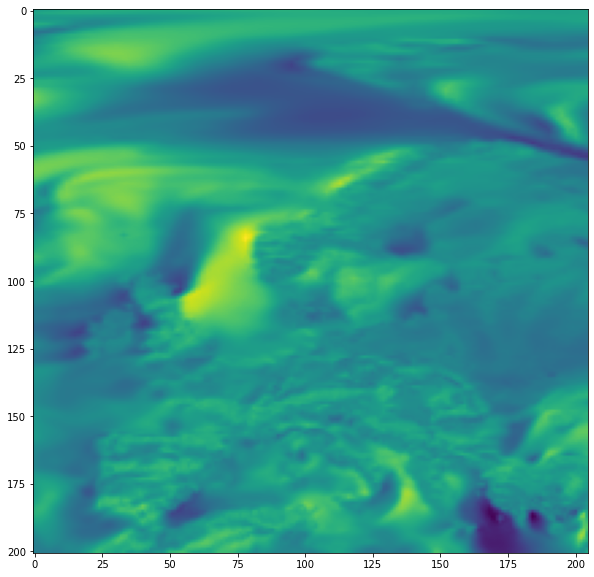

In [5]:
#Testing the download for a single date
with Connection('localhost') as c:
    c.local('rm -f world.nc')
    
date = datetime.datetime(1990,5,5)
getFile('world.nc',date)

data = xr.load_dataset('world.nc')
v10 = data['v10'][0,:,:]
plt.figure(figsize = (20,10))
plt.imshow(v10.values)

In [7]:
# %%capture
#Actually downloading the data for all the dates of interest
Parallel(n_jobs=max_workers)(delayed(getData)(date) for date in tqdm(date_generated))

 86%|████████▌ | 13280/15399 [71:54:24<56:48:23, 96.51s/it]  

KeyboardInterrupt: 

## Check all files have been downloaded

In [21]:
%%capture
#Checking if all the files in the list of dates have been downloaded
from parse import *

#Getting the dates that have been downloaded from the file name
with Connection('localhost') as c:
    a = c.local('cd {} && ls -1 *.nc'.format(download_dir,hide='stdout'))
#     display(a)                
a = a.stdout.split('\n')
a = [ parse('europe_{d}-{m}-{Y}.nc',i) for i in a]
a = [i.named for i in a  if i is not None]
a = [datetime.datetime(int(i['Y']),int(i['m']),int(i['d'])) for i in a]


#Checking the difference between the downloaded files and the list of dates:
missing_files = list(set(date_generated) - set(a))
missing_files.sort()


In [22]:
display(len(missing_files))

2156

In [25]:
import pickle
with open('missing.pickle','wb') as f:
    pickle.dump(missing_files,f,protocol=pickle.HIGHEST_PROTOCOL)
    
with open('missing.pickle','rb') as f:
    bla = pickle.load(f)
    
display(len(bla))

2156

In [26]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     InlineBackend
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [27]:
**config

SyntaxError: invalid syntax (<ipython-input-27-ab8494af9f4d>, line 1)